# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.948285,True,2.882150
1,-2.415717,True,0.770062
2,-1.382551,False,-2.610313
3,-2.102173,False,-2.845485
4,-1.985122,False,-4.040281
...,...,...,...
995,1.146055,True,5.640168
996,-1.377612,True,2.990113
997,-1.962740,False,-3.439705
998,-1.970949,False,-2.641655


<AxesSubplot: xlabel='v0'>

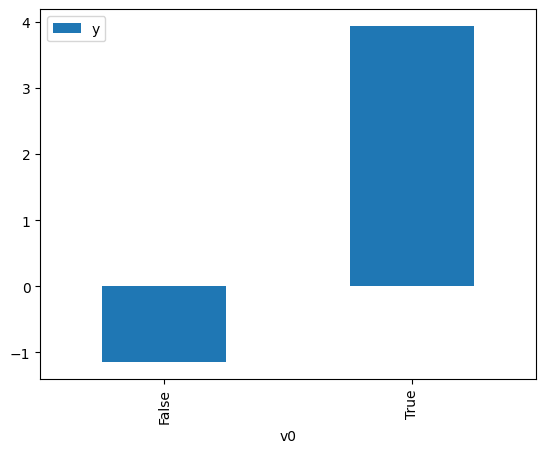

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

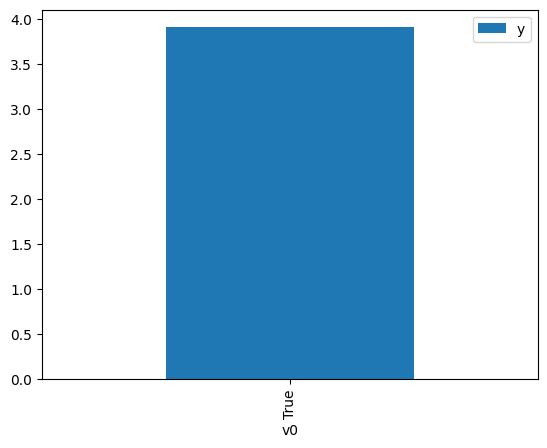

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.993255,False,-0.006908,0.590904,1.692323
1,-1.131767,False,-1.739774,0.603068,1.658187
2,-2.023032,False,-2.209374,0.677789,1.475386
3,-0.093080,False,-0.324000,0.509771,1.961665
4,-2.127547,False,-2.225206,0.686064,1.457590
...,...,...,...,...,...
995,0.401115,False,1.392844,0.464729,2.151792
996,0.821832,False,0.654570,0.426804,2.342997
997,0.218222,False,0.092892,0.481370,2.077403
998,-1.161459,False,-2.270676,0.605660,1.651091


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.415717,True,0.770062,0.291734,3.427784
1,-3.107685,True,0.105290,0.242397,4.125472
2,0.503368,True,5.162747,0.544543,1.836401
3,1.077202,True,6.707015,0.595832,1.678326
4,-1.096099,True,2.832889,0.400053,2.499671
...,...,...,...,...,...
995,0.229551,True,5.524582,0.519662,1.924327
996,0.082827,True,5.281356,0.506281,1.975186
997,-0.073521,True,3.225619,0.492013,2.032465
998,0.106791,True,5.624169,0.508468,1.966693


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.919
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                              5646.
Date:                Thu, 22 Dec 2022   Prob (F-statistic):                        0.00
Time:                        14:17:09   Log-Likelihood:                         -1444.9
No. Observations:                1000   AIC:                                      2894.
Df Residuals:                     998   BIC:                                      2904.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6970      0.028     60.953      0.000       1.642       1.752
x2             4.9522      0.050     98.808      0.000       4.854       5.051
==============================================================================
Omnibus:                        0.359   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.836   Jarque-Bera (JB):                0.284
Skew:                           0.036   Prob(JB):                        0.868
Kurtosis:                       3.042   Cond. No.                         1.89
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""